## Anomaly Detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Generate synthetic time series data
def generate_synthetic_data(seq_length=1000, num_anomalies=10):
    normal_data = np.sin(np.linspace(0,50,seq_length))
    anomaly_data = normal_data.copy()
    anomaly_indices = np.random.choice(seq_length, num_anomalies, replace=False)
    anomaly_data[anomaly_indices] = anomaly_data[anomaly_indices] + np.random.normal(0, 1, num_anomalies)
    return normal_data, anomaly_data, anomaly_indices

In [3]:
# Reshape data for RNN input
def create_dataset(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [4]:
time_steps = 50
normal_data, anomaly_data, _ = generate_synthetic_data()

In [5]:
# Create datasets
X_train, y_train = create_dataset(anomaly_data, time_steps)
X_test, y_test = create_dataset(anomaly_data, time_steps)

In [6]:
# Normalize data
scaler = MinMaxScaler()
X_train_flat = X_train.reshape(-1, 1) # flatten to 2D for scaler
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(-1, time_steps, 1) # back to 3D after scaling
y_train_scaled = scaler.transform(y_train.reshape(-1,1))
X_test_flat = X_test.reshape(-1,1)
X_test_scaled = scaler.transform(X_test_flat).reshape(-1, time_steps, 1)
y_test_scaled = scaler.transform(y_test.reshape(-1,1))

In [7]:
# Build RNN model
model = Sequential()
model.add(LSTM(50, input_shape=(time_steps, 1), return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2025-03-13 12:39:57.690392: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-13 12:39:57.690442: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-03-13 12:39:57.690447: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-03-13 12:39:57.690475: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-13 12:39:57.690491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/jorocca/tf_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential 

In [8]:
# Train model
history = model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10


2025-03-13 12:39:58.070371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1065 - val_loss: 0.0072
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0088 - val_loss: 0.0040
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 6.4721e-05
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.9589e-04 - val_loss: 1.8507e-05
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.6440e-04 - val_loss: 6.9873e-05
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.5039e-04 - val_loss: 1.0111e-04
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8091e-04 - val_loss: 2.2900e-05
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.4651e-04 - val_loss: 1.2235e-05


In [9]:
# Predictions
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


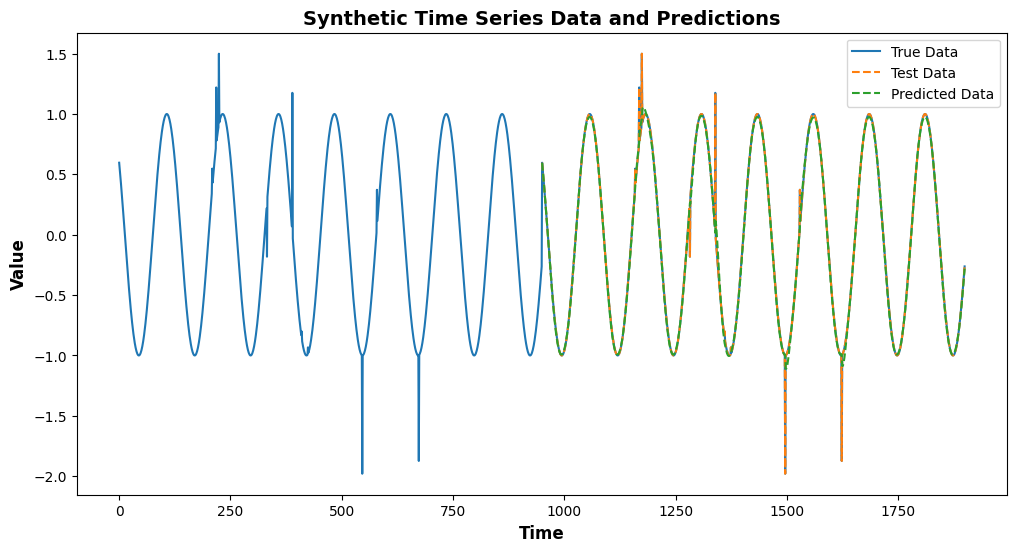

In [11]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(np.concatenate([y_train, y_test]), label='True Data')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test Data', linestyle='--')
plt.plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred, label='Predicted Data', linestyle='--')
plt.title('Synthetic Time Series Data and Predictions', fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')
plt.legend()
plt.show()